데이터 군집

In [3]:
import os
os.chdir("ml-powered-app")
%pwd

'C:\\Users\\ftmlab\\Documents\\hyoon\\side_project\\ml-powered-app'

In [8]:
import pandas as pd
import spacy
import umap
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author, add_text_features_to_df, get_vectorized_series, train_vectorizer

data_path = Path("./data/processed/writers/writers.csv")
df = pd.read_csv(data_path, index_col=0)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df["is_question"]].copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])
train_author["vector"] = train_author["full_text"].apply(lambda x: nlp(x).vector)
vectorized_features = np.vstack(train_author["vector"])

In [16]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

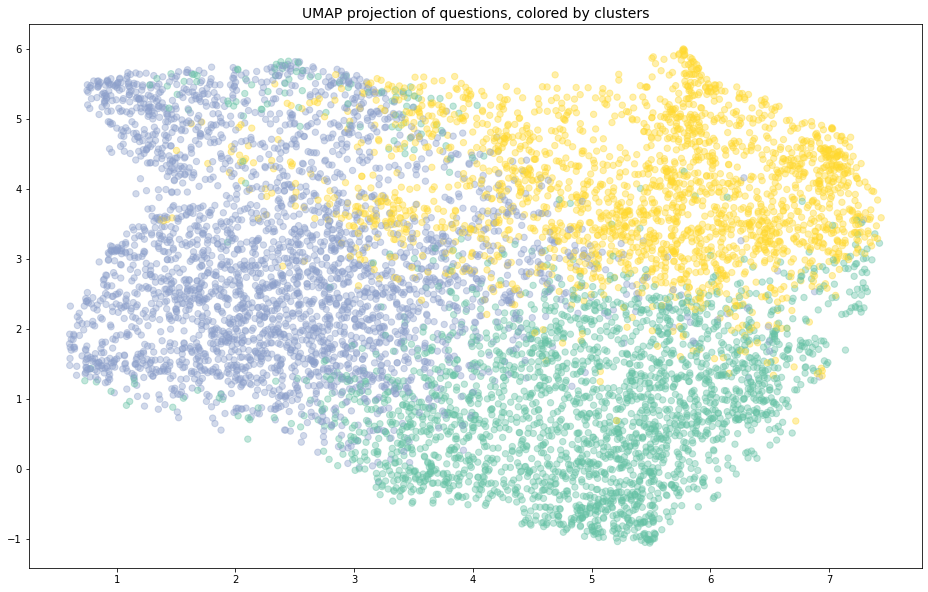

In [18]:
# 클러스터 개수와 컬러맵 선택
n_clusters = 3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# 벡터화된 특성에 군집 알고리즘 훈련
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# 차원 축소된 특성 2D 출력
# 군집은 축소(umap)전 벡터 데이터로, 시각화는 umap사용
plt.scatter(umap_features[:, 0], umap_features[:, 1],
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title("UMAP projection of questions, colored by clusters", fontsize=14)
plt.savefig("./images/bmlpa_figures/ch04-10.png", dpi=300)

KMeans 알고리즘은 각 샘플을 클러스터 중심까지의 거리로 표현가능. (`transform()` 매서드 사용)   
클러스터 개수만큼 특성이 생긴다.   
중심까지의 거리를 통해 시각화를 하면 종종 더 나은 결과를 보여준다.

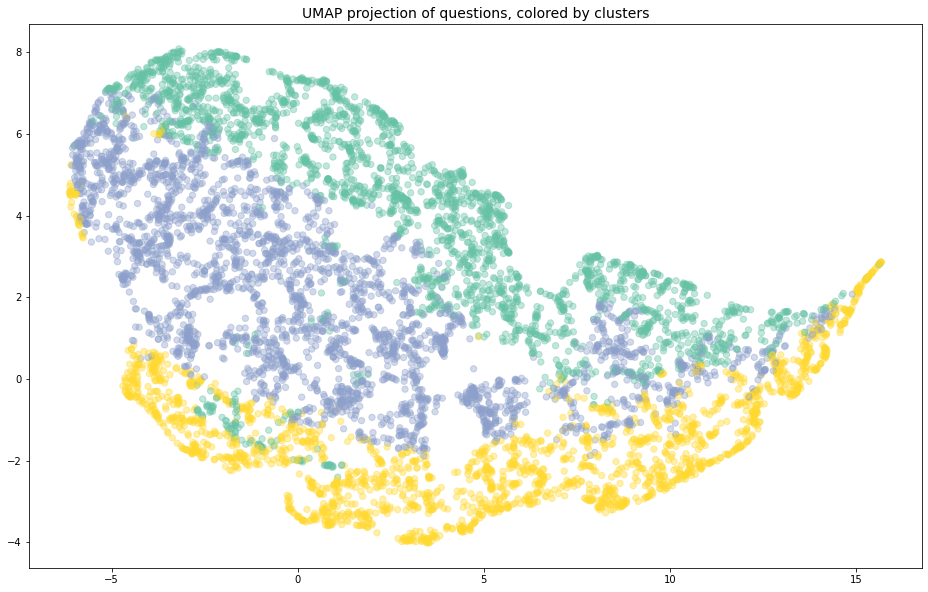

In [19]:
# 중심까지의 거리로 데이터 변환 후 umap 축소 
transformed_features = clus.transform(vectorized_features)
umap_features = umap_embedder.fit_transform(transformed_features)

fig = plt.figure(figsize=(16, 10))

plt.scatter(umap_features[:, 0], umap_features[:, 1], c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14)
plt.savefig('./images/bmlpa_figures/ch04-10A.png', dpi=300)

위 그래프만 가지고는 클러스터 개수가 올바른지 확신할 수 없다.   
실루엣 점수는 판단 기준 중 하나로써 사용가능하다.

For n_clusters = 2, The average silhouette_score is: 0.15690840780735016
(2, 300)
For n_clusters = 3, The average silhouette_score is: 0.07960157096385956
(3, 300)
For n_clusters = 4, The average silhouette_score is: 0.06504553556442261
(4, 300)
For n_clusters = 5, The average silhouette_score is: 0.04933353140950203
(5, 300)
For n_clusters = 6, The average silhouette_score is: 0.03498534485697746
(6, 300)


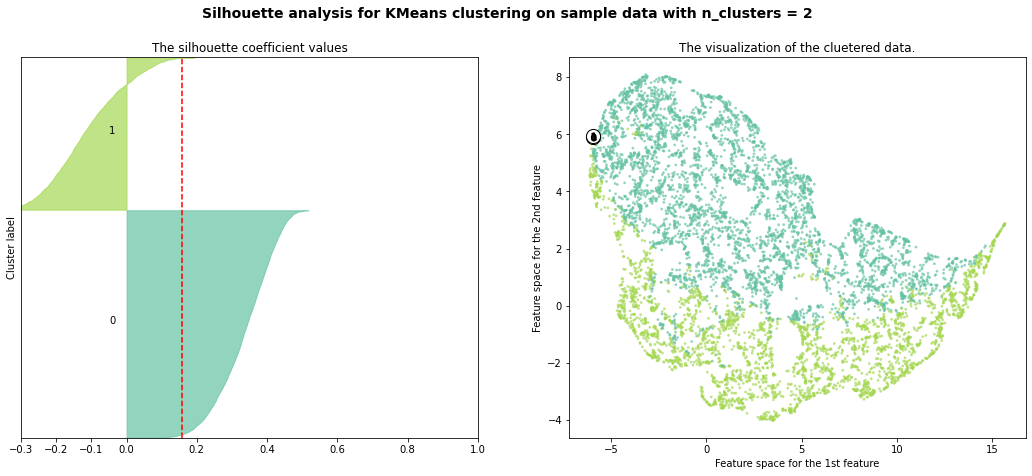

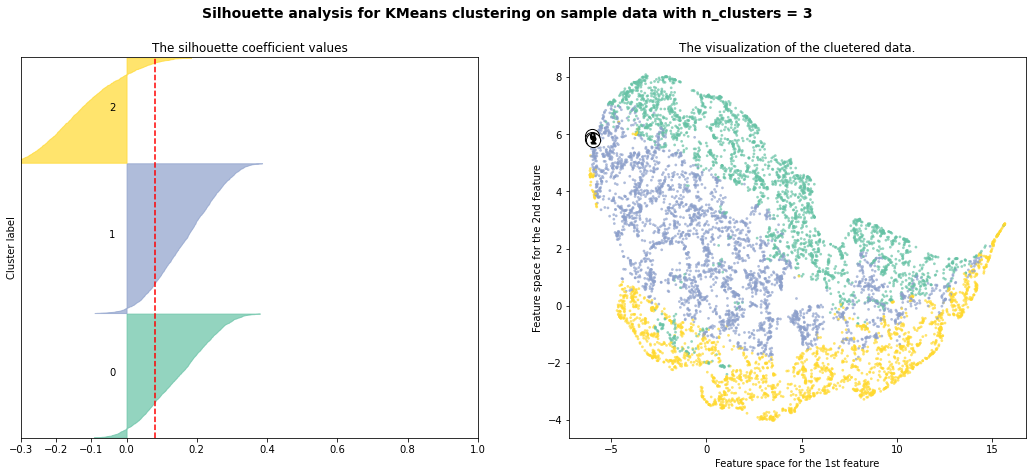

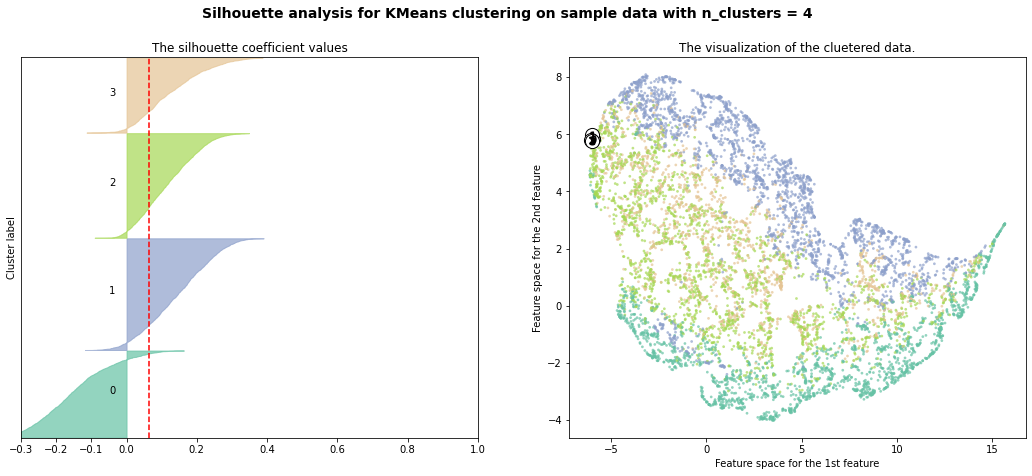

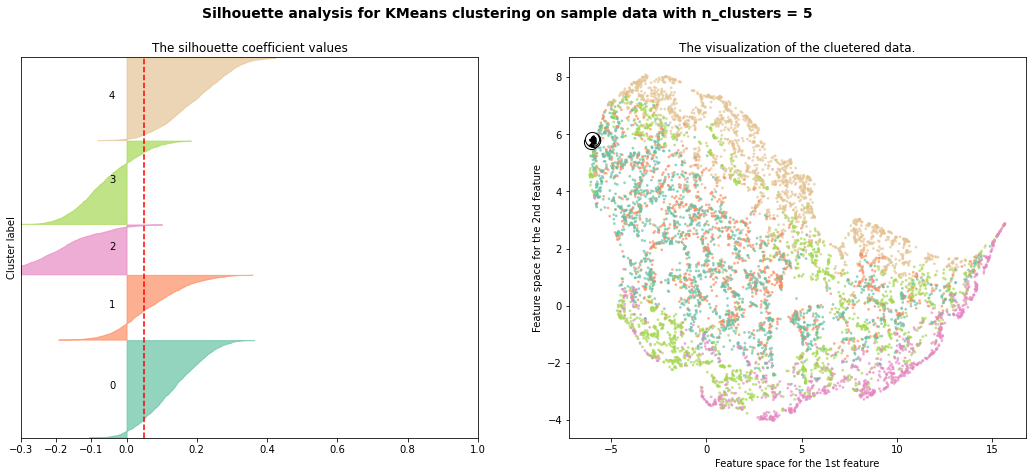

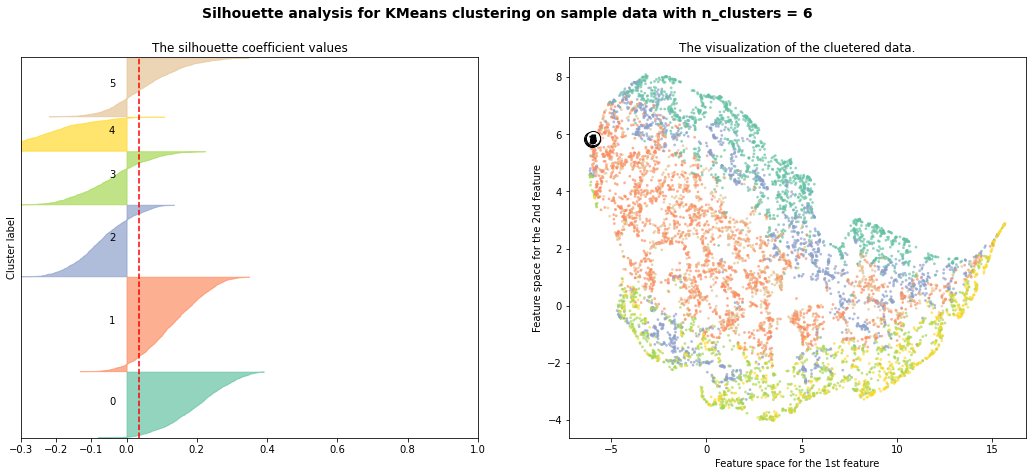

In [27]:
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # 1행 2열의 서브 플롯
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # 실루엣 계수는 -1 ~ 1 사이 갑을 갖는다. (이 예시에서는 모두 0.1~1 사이에 있다.)
    ax1.set_xlim([-.3, .4])
    # (n_clusters + 1) * 10 => 클러스터 실루엣 그래프 사이의 공백을 위함
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])
    
    # n_cluster와 재현을 위한 random_state 지정
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)
    
    # silhouette_score 함수는 모든 샘플에 대한 평균을 반환.
    # 이를 통해 만들어진 클러스터의 조밀함과 차별성 판단.
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg}")
    
    # 각 샘플들에 대한 실루엣 점수 계산
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10 # 샘플이 0 개일 경우를 고려하여 10을 더한다.
        
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_title("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) # y축 레이블 삭제
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2D 평면에 실제 클러스터 그리기
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # 클러스터에 레이블 부여
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # 클러스터 중심에 하얀 원 생성
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        
    ax2.set_title("The visualization of the cluetered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  f"with n_clusters = {n_clusters}"
                  ), fontsize=14, fontweight='bold')
    
    

최적은 없지만 그나마 3~4개의 클러스터가 적절해 보인다.